# Import Libraries

In [3]:
import os

import pandas as pd
import numpy as np
import missingno as msno
import impyute as impy
import miceforest as mf

from statsmodels.multivariate.pca import PCA
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA as sklearnPCA

from MissForest import MissForest

from matplotlib import pyplot as plt
import seaborn as sns

import datawig

# Lab Values

## Load Data

In [4]:
path = os.getcwd() + '/../../data/mimic_top_labs.csv'
originalDf = pd.read_csv(path)

In [5]:
originalDf.head()

,Unnamed: 0,hadm_id,glucose,hemoglobin,anion_gap,bicarbonate,calcium_total,chloride,creatinine,magnesium,...,sodium,urea_nitrogen,hematocrit,mch,mchc,mcv,platelet_count,rdw,red_blood_cells,white_blood_cells
0,0,20000094,286.5,13.05,27.0,23.500000,8.55,84.000000,3.85,2.1,...,130.0,99.00,41.100000,27.75,31.75,87.5,104.5,20.45,4.705,12.40
1,1,20000147,180.6,11.24,16.0,22.333333,NaN,100.333333,0.70,2.3,...,132.5,14.25,32.566667,30.94,33.94,91.4,244.0,12.38,3.660,9.08
2,2,20000351,1000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,20000397,NaN,NaN,NaN,NaN,NaN,NaN,0.95,2.1,...,138.5,16.00,48.100000,NaN,NaN,NaN,185.0,NaN,NaN,5.20
4,4,20000808,138.5,12.70,14.5,23.000000,9.50,104.500000,0.70,1.9,...,137.5,14.00,36.800000,30.30,34.60,87.5,321.0,13.20,4.200,9.90


In [6]:
originalDf = originalDf.iloc[: , 1:]
originalDf.set_index('hadm_id', inplace=True)

In [7]:
originalDf.head()

,glucose,hemoglobin,anion_gap,bicarbonate,calcium_total,chloride,creatinine,magnesium,phosphate,potassium,sodium,urea_nitrogen,hematocrit,mch,mchc,mcv,platelet_count,rdw,red_blood_cells,white_blood_cells
hadm_id,,,,,,,,,,,,,,,,,,,,
20000094,286.5,13.05,27.0,23.500000,8.55,84.000000,3.85,2.1,6.65,4.45,130.0,99.00,41.100000,27.75,31.75,87.5,104.5,20.45,4.705,12.40
20000147,180.6,11.24,16.0,22.333333,NaN,100.333333,0.70,2.3,3.50,4.30,132.5,14.25,32.566667,30.94,33.94,91.4,244.0,12.38,3.660,9.08
20000351,1000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20000397,NaN,NaN,NaN,NaN,NaN,NaN,0.95,2.1,NaN,4.45,138.5,16.00,48.100000,NaN,NaN,NaN,185.0,NaN,NaN,5.20
20000808,138.5,12.70,14.5,23.000000,9.50,104.500000,0.70,1.9,3.70,4.55,137.5,14.00,36.800000,30.30,34.60,87.5,321.0,13.20,4.200,9.90


## Visualize Missing Proportion

In [8]:
missingSeries = originalDf.isna().sum().sort_values()

In [9]:
missingSeries

creatinine            214
potassium             229
glucose               235
urea_nitrogen         242
chloride              253
sodium                253
hematocrit            254
bicarbonate           292
hemoglobin            311
anion_gap             314
platelet_count        342
white_blood_cells     344
red_blood_cells       357
mcv                   358
mchc                  363
mch                   364
rdw                   371
magnesium            1264
calcium_total        3389
phosphate            3413
dtype: int64

<AxesSubplot: >

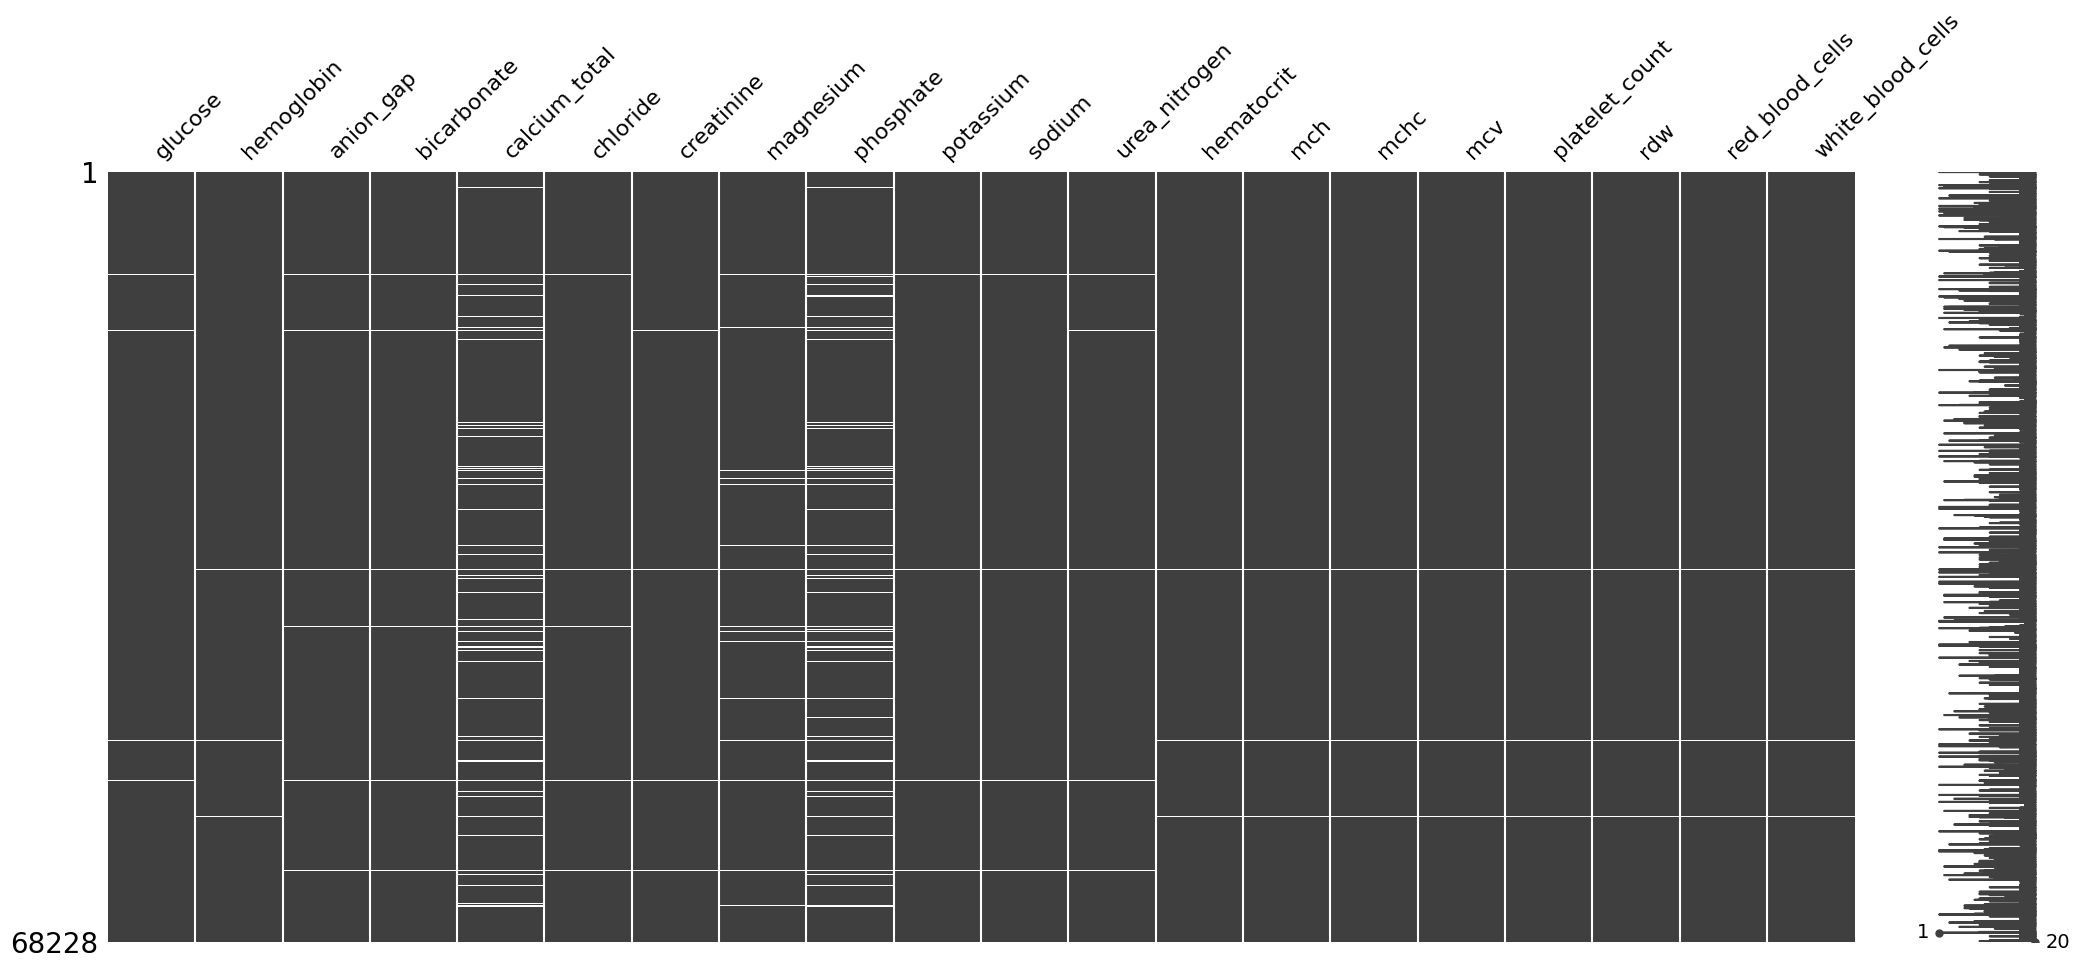

In [10]:
msno.matrix(originalDf)

<AxesSubplot: >

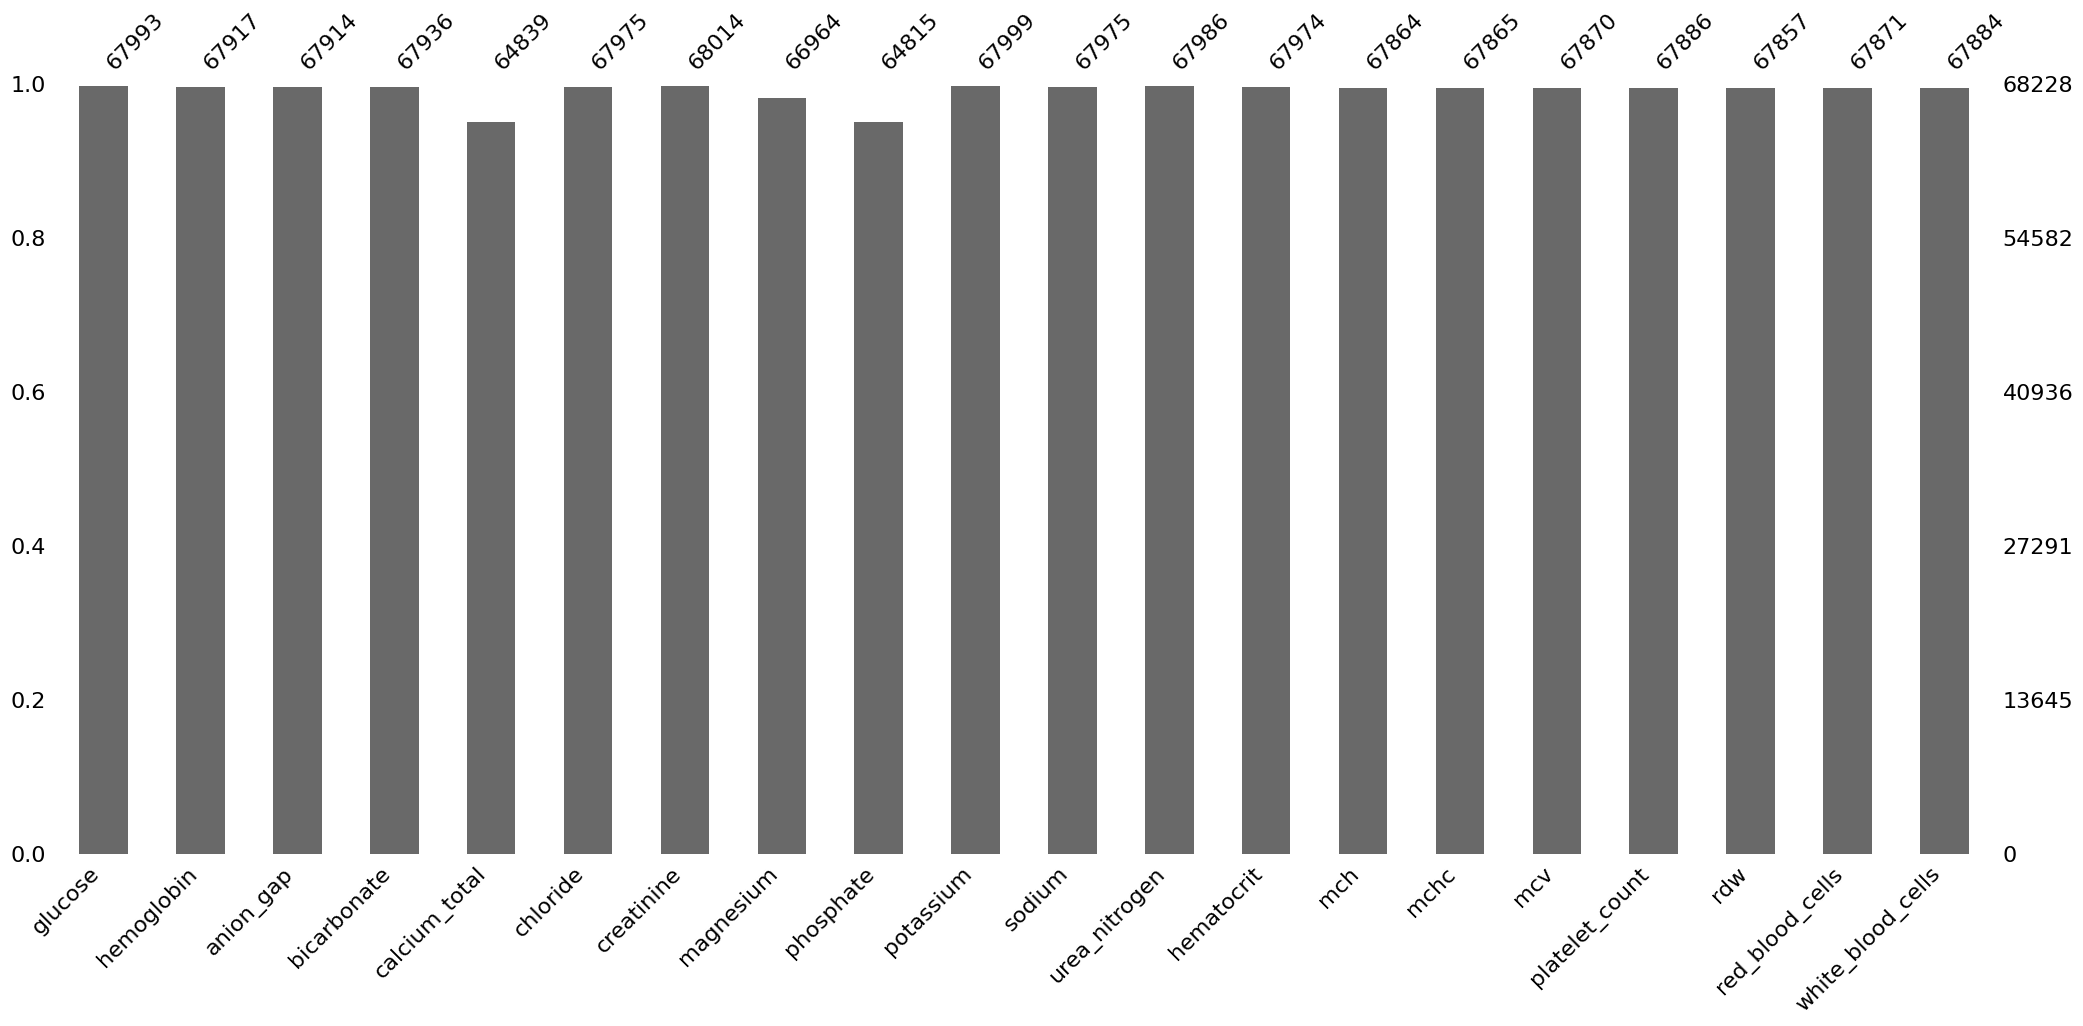

In [11]:
msno.bar(originalDf)

## Drop Rows with Missing Values

In [12]:
dataDf = originalDf.dropna()

In [13]:
dataDf.isna().sum().sort_values()

glucose              0
rdw                  0
platelet_count       0
mcv                  0
mchc                 0
mch                  0
hematocrit           0
urea_nitrogen        0
sodium               0
potassium            0
phosphate            0
magnesium            0
creatinine           0
chloride             0
calcium_total        0
bicarbonate          0
anion_gap            0
hemoglobin           0
red_blood_cells      0
white_blood_cells    0
dtype: int64

<AxesSubplot: >

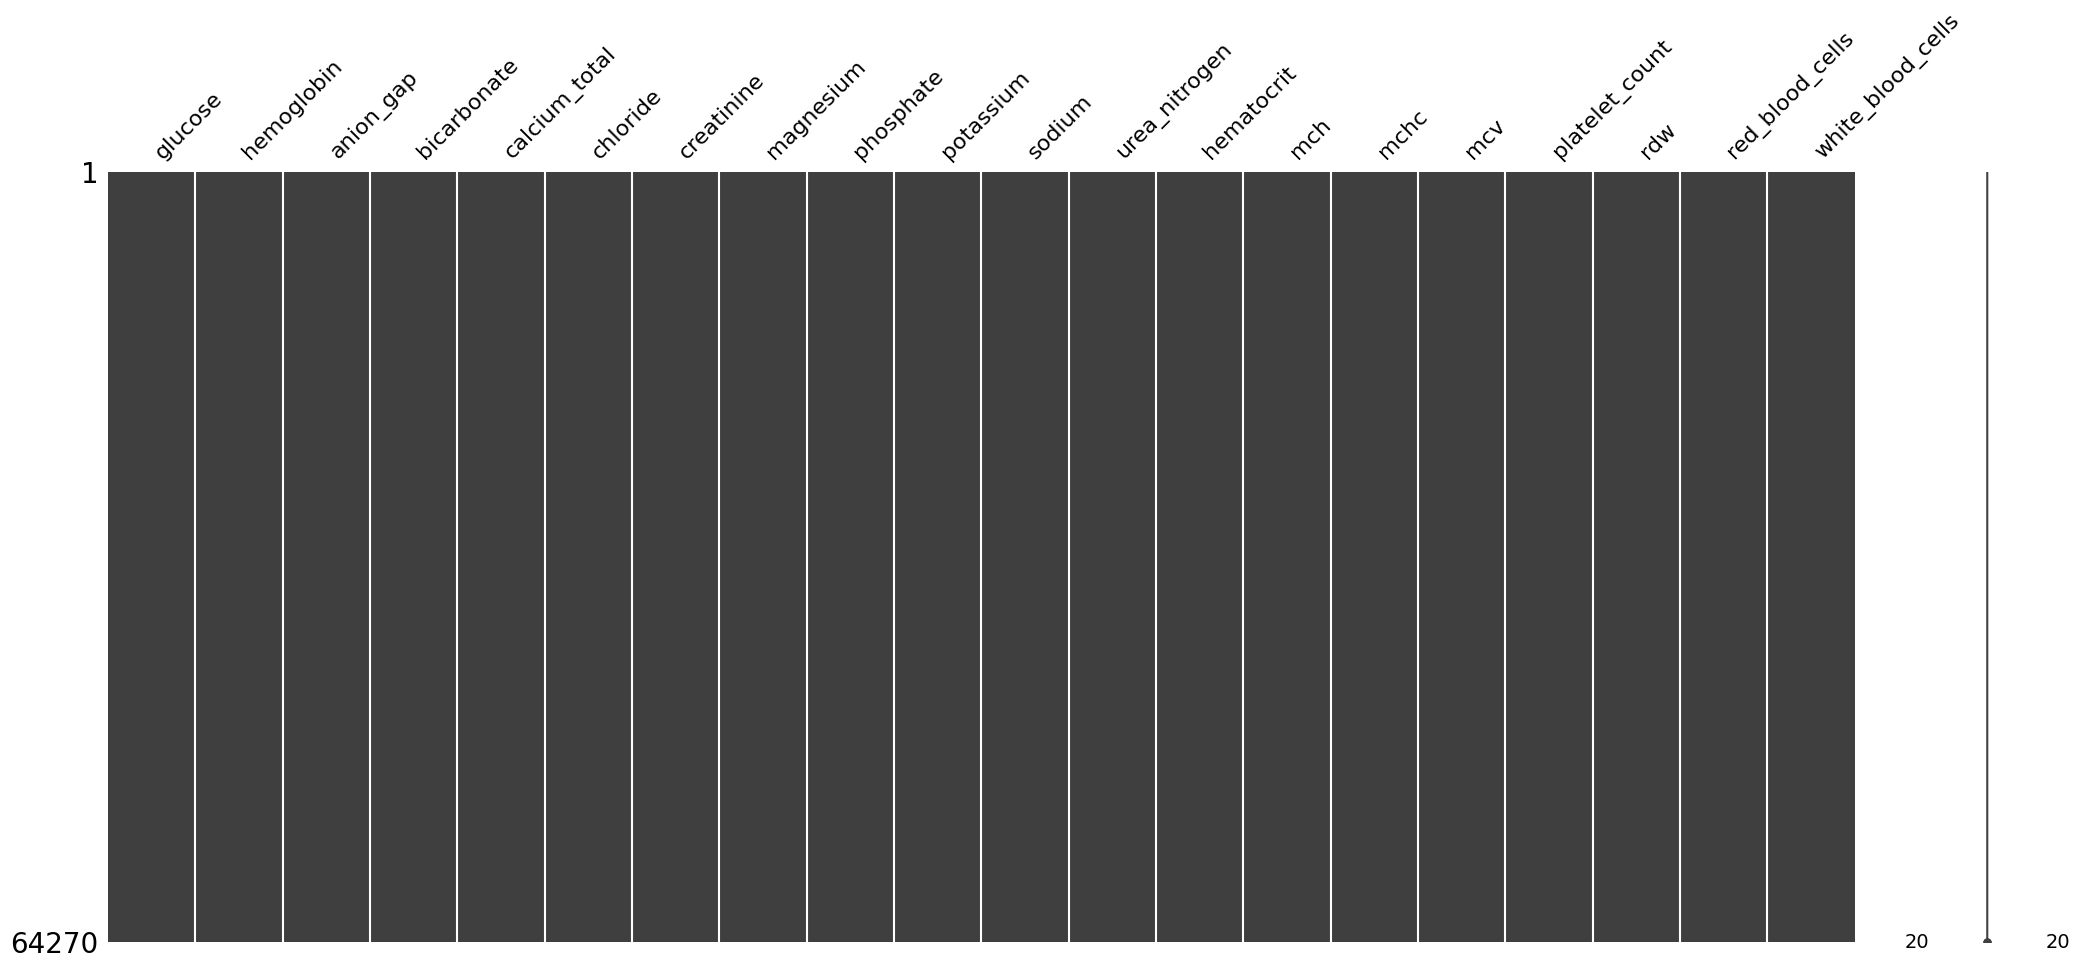

In [14]:
msno.matrix(dataDf)

## Imputation for different proportions of missing data

In [14]:
plotData = []
for p in [*range(1, 50, 3)]:

    print('p: ', p)

    proportions = (p/100), round((1-(p/100)), 2)
    mask = np.random.choice(a=[True, False], size=dataDf.shape, p=proportions)
    missingDf = dataDf.mask(mask)

    meanImputer = SimpleImputer(strategy='mean')
    meanImputedData = meanImputer.fit_transform(missingDf)
    meanImputedDf = pd.DataFrame(meanImputedData, columns=[(col + '_mean') for col in missingDf.columns], index=missingDf.index)
    meanMse = mean_squared_error(dataDf, meanImputedDf)
    meanR2 = r2_score(dataDf, meanImputedDf)

    medianImputer = SimpleImputer(strategy='median')
    medianImputedData = medianImputer.fit_transform(missingDf)
    medianImputedDf = pd.DataFrame(medianImputedData, columns=[(col + '_median') for col in missingDf.columns], index=missingDf.index)
    medianMse = mean_squared_error(dataDf, medianImputedDf)
    medianR2 = r2_score(dataDf, medianImputedDf)

    knnImputer = KNNImputer()
    knnImputedData = knnImputer.fit_transform(missingDf)
    knnImputedDf = pd.DataFrame(knnImputedData, columns=[(col + '_knn') for col in missingDf.columns], index=missingDf.index)
    knnMse = mean_squared_error(dataDf, knnImputedDf)
    knnR2 = r2_score(dataDf, knnImputedDf)

    mfImputer = MissForest()
    mfImputedData = mfImputer.fit_transform(missingDf)
    mfImputedDf = pd.DataFrame(mfImputedData, columns=[(col + '_mf') for col in missingDf.columns], index=missingDf.index)
    mfMse = mean_squared_error(dataDf, mfImputedDf)
    mfR2 = r2_score(dataDf, mfImputedDf)

    pc = PCA(data=missingDf, ncomp=1, missing='fill-em', method='nipals')
    nipalsImputedDf = pd.DataFrame(pc._adjusted_data)
    nipalsMse = mean_squared_error(dataDf, nipalsImputedDf)
    nipalsR2 = r2_score(dataDf, nipalsImputedDf)

    dwImputedDf = datawig.SimpleImputer.complete(missingDf)
    dwMse = mean_squared_error(dataDf, dwImputedDf)
    dwR2 = r2_score(dataDf, dwImputedDf)

    emImputedData = impy.em(missingDf.to_numpy())
    emImputedDataDf = pd.DataFrame(emImputedData, columns=[(col + '_em') for col in missingDf.columns], index=missingDf.index)
    emMse = mean_squared_error(dataDf, emImputedDataDf)
    emR2 = r2_score(dataDf, emImputedDataDf)

    # Create kernel. 
    miKernel = mf.ImputationKernel(
      missingDf,
      datasets=4,
      save_all_iterations=True,
      random_state=1
    )
    # Run the MICE algorithm for 2 iterations on each of the datasets
    miKernel.mice(2)
    miImputedDataDf = miKernel.complete_data(dataset=0, inplace=False)
    miImputedDf = pd.DataFrame(miImputedDataDf.to_numpy(), columns=[(col + '_mi') for col in missingDf.columns], index=missingDf.index)
    miMse = mean_squared_error(dataDf, miImputedDf)
    miR2 = r2_score(dataDf, miImputedDf)

    plotData.append([p, meanMse, medianMse, knnMse, mfMse, nipalsMse, dwMse, emMse, miMse, meanR2, medianR2, knnR2, mfR2, nipalsR2, dwR2, emR2, miR2])

plotDf = pd.DataFrame(plotData, columns=['missing_proportion', 'mean_mse', 'median_mse', 'knn_mse', 'mf_mse', 'nipals_mse', 'dw_mse', 'em_mse', 'mi_mse', 'mean_r2', 'median_r2', 'knn_r2', 'mf_r2', 'nipals_r2', 'dw_r2', 'em_r2', 'mi_r2'])

p:  1
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


/superbugai-data/yash/chapter_1/workspace/EHRQC/notebooks/.venv/lib/python3.9/site-packages/lightgbm/engine.py:240: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/superbugai-data/yash/chapter_1/workspace/EHRQC/notebooks/.venv/lib/python3.9/site-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


p:  4
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


/superbugai-data/yash/chapter_1/workspace/EHRQC/notebooks/.venv/lib/python3.9/site-packages/lightgbm/engine.py:240: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/superbugai-data/yash/chapter_1/workspace/EHRQC/notebooks/.venv/lib/python3.9/site-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


p:  7
Iteration: 0
Iteration: 1
Iteration: 2


/superbugai-data/yash/chapter_1/workspace/EHRQC/notebooks/.venv/lib/python3.9/site-packages/lightgbm/engine.py:240: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/superbugai-data/yash/chapter_1/workspace/EHRQC/notebooks/.venv/lib/python3.9/site-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


p:  10
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


/superbugai-data/yash/chapter_1/workspace/EHRQC/notebooks/.venv/lib/python3.9/site-packages/lightgbm/engine.py:240: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/superbugai-data/yash/chapter_1/workspace/EHRQC/notebooks/.venv/lib/python3.9/site-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


p:  13
Iteration: 0
Iteration: 1
Iteration: 2


/superbugai-data/yash/chapter_1/workspace/EHRQC/notebooks/.venv/lib/python3.9/site-packages/lightgbm/engine.py:240: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/superbugai-data/yash/chapter_1/workspace/EHRQC/notebooks/.venv/lib/python3.9/site-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


p:  16
Iteration: 0
Iteration: 1
Iteration: 2


/superbugai-data/yash/chapter_1/workspace/EHRQC/notebooks/.venv/lib/python3.9/site-packages/lightgbm/engine.py:240: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/superbugai-data/yash/chapter_1/workspace/EHRQC/notebooks/.venv/lib/python3.9/site-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


p:  19
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


/superbugai-data/yash/chapter_1/workspace/EHRQC/notebooks/.venv/lib/python3.9/site-packages/lightgbm/engine.py:240: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/superbugai-data/yash/chapter_1/workspace/EHRQC/notebooks/.venv/lib/python3.9/site-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


p:  22
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8


/superbugai-data/yash/chapter_1/workspace/EHRQC/notebooks/.venv/lib/python3.9/site-packages/lightgbm/engine.py:240: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/superbugai-data/yash/chapter_1/workspace/EHRQC/notebooks/.venv/lib/python3.9/site-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


p:  25
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


/superbugai-data/yash/chapter_1/workspace/EHRQC/notebooks/.venv/lib/python3.9/site-packages/lightgbm/engine.py:240: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/superbugai-data/yash/chapter_1/workspace/EHRQC/notebooks/.venv/lib/python3.9/site-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


p:  28
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


/superbugai-data/yash/chapter_1/workspace/EHRQC/notebooks/.venv/lib/python3.9/site-packages/lightgbm/engine.py:240: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/superbugai-data/yash/chapter_1/workspace/EHRQC/notebooks/.venv/lib/python3.9/site-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


p:  31
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6


/superbugai-data/yash/chapter_1/workspace/EHRQC/notebooks/.venv/lib/python3.9/site-packages/lightgbm/engine.py:240: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/superbugai-data/yash/chapter_1/workspace/EHRQC/notebooks/.venv/lib/python3.9/site-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


p:  34
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


/superbugai-data/yash/chapter_1/workspace/EHRQC/notebooks/.venv/lib/python3.9/site-packages/lightgbm/engine.py:240: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/superbugai-data/yash/chapter_1/workspace/EHRQC/notebooks/.venv/lib/python3.9/site-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


p:  37
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5


/superbugai-data/yash/chapter_1/workspace/EHRQC/notebooks/.venv/lib/python3.9/site-packages/lightgbm/engine.py:240: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/superbugai-data/yash/chapter_1/workspace/EHRQC/notebooks/.venv/lib/python3.9/site-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


p:  40
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7


/superbugai-data/yash/chapter_1/workspace/EHRQC/notebooks/.venv/lib/python3.9/site-packages/lightgbm/engine.py:240: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/superbugai-data/yash/chapter_1/workspace/EHRQC/notebooks/.venv/lib/python3.9/site-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


p:  43
Iteration: 0
Iteration: 1
Iteration: 2


/superbugai-data/yash/chapter_1/workspace/EHRQC/notebooks/.venv/lib/python3.9/site-packages/lightgbm/engine.py:240: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/superbugai-data/yash/chapter_1/workspace/EHRQC/notebooks/.venv/lib/python3.9/site-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


p:  46
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


/superbugai-data/yash/chapter_1/workspace/EHRQC/notebooks/.venv/lib/python3.9/site-packages/lightgbm/engine.py:240: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/superbugai-data/yash/chapter_1/workspace/EHRQC/notebooks/.venv/lib/python3.9/site-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


p:  49
Iteration: 0
Iteration: 1
Iteration: 2


/superbugai-data/yash/chapter_1/workspace/EHRQC/notebooks/.venv/lib/python3.9/site-packages/lightgbm/engine.py:240: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/superbugai-data/yash/chapter_1/workspace/EHRQC/notebooks/.venv/lib/python3.9/site-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


In [15]:
plotDf.to_csv('temp_plot_df.csv')

In [16]:
plotDf

,missing_proportion,mean_mse,median_mse,knn_mse,mf_mse,nipals_mse,dw_mse,em_mse,mi_mse,mean_r2,median_r2,knn_r2,mf_r2,nipals_r2,dw_r2,em_r2,mi_r2
0,1,7.919152,8.216442,7.785102,6.053300,7.959291,7.305145,443.031632,12.008547,0.990810,0.990592,0.993422,0.996848,0.991911,0.985596,0.981987,0.993654
1,4,28.404041,29.244180,27.522750,22.435893,28.396383,48.990094,1678.514882,44.218936,0.962590,0.961815,0.973487,0.987482,0.967650,0.985176,0.926795,0.973454
2,7,47.170028,48.523393,46.389192,36.823456,46.936298,54.619832,3309.609775,76.918129,0.932387,0.930938,0.949765,0.974075,0.941142,0.546467,0.870160,0.948984
3,10,71.224916,73.459965,72.398361,61.747122,71.030553,485.648315,4636.359642,110.808997,0.906262,0.904467,0.928348,0.964719,0.917800,0.775805,0.817229,0.927636
4,13,97.885631,101.332068,97.905838,7771.090070,97.536177,348.750030,5999.143792,146.383070,0.876478,0.873837,0.904473,0.944129,0.891452,-0.459600,0.759045,0.901125
5,16,110.420932,113.311893,113.465732,656.014500,111.031763,162.151292,7807.555479,179.669840,0.848580,0.845497,0.880769,0.938524,0.867081,-25.812292,0.705588,0.874999
6,19,138.560498,142.717933,145.702515,2573.361712,138.961205,146.734766,9509.224176,220.943961,0.819232,0.815679,0.851830,0.919191,0.840255,0.483266,0.649465,0.844074
7,22,50836.098956,50846.499571,50845.753648,50806.144546,50828.666587,50797.519358,50994.498586,50875.378264,0.742184,0.737944,0.775305,0.860229,0.767119,0.853831,0.555005,0.766366
8,25,183.371584,189.010358,195.548325,3603.661519,184.929120,388.032327,13576.101614,297.767648,0.759896,0.754911,0.790573,0.886631,0.787255,-7.243281,0.532293,0.778204
9,28,201.438511,207.111684,221.997600,8115.327797,211.400254,4060.207309,15276.303623,327.504557,0.731022,0.725679,0.755877,0.863073,0.760503,-58.911236,0.475600,0.742238


In [32]:
import pandas as pd

plotDf = pd.read_csv('temp_plot_df.csv')

In [33]:
plotDf

,Unnamed: 0,missing_proportion,mean_mse,median_mse,knn_mse,mf_mse,nipals_mse,em_mse,mi_mse,mean_r2,median_r2,knn_r2,mf_r2,nipals_r2,em_r2,mi_r2
0,0,1,0.930491,0.934704,0.452241,1.132301,0.922256,153.621532,0.681113,0.995998,0.994687,0.997437,0.998585,0.997863,0.987454,0.996911
1,1,4,3.471427,3.488002,18.898202,15.219791,3.499545,624.856945,4.018969,0.983666,0.978630,0.988833,0.992320,0.991493,0.948539,0.987912
2,2,7,7.326304,7.353821,312.364742,2493.204082,7.332659,1161.252585,56.690300,0.971417,0.963205,0.974775,0.951778,0.984951,0.909184,0.972119
3,3,10,499.366805,499.696324,533.744554,1799.792876,499.395908,2227.615692,612.201201,0.846532,0.834640,0.856447,0.852543,0.865135,0.765354,0.840715
4,4,13,1889.671357,1890.141512,1896.005684,1975.066443,1889.614703,4037.936537,2078.006368,0.821347,0.806479,0.839378,0.846974,0.843071,0.712604,0.833296
5,5,16,16527.937809,16529.140238,16601.194239,16549.264536,16528.166388,17124.688364,16566.698288,0.720149,0.700785,0.736919,0.755805,0.747507,0.598249,0.730859
6,6,19,9800.245056,9801.454624,9860.299768,9820.559567,9800.932116,11652.938532,9876.832799,0.780864,0.758559,0.796860,0.820121,0.803668,0.619880,0.786951
7,7,22,147.505136,147.621647,160.050937,1836.414776,983.768645,4530.613666,195.449501,0.903417,0.876416,0.927165,0.922766,0.395484,0.683880,0.912940
8,8,25,7854.117599,7854.720257,7901.870734,8017.500594,7858.401243,10918.202941,7970.110354,0.705047,0.674866,0.732719,0.746018,0.716681,0.498643,0.704345
9,9,28,565.447988,565.958750,582.177361,4587.532752,583.297505,6534.859547,700.326280,0.858515,0.824906,0.887056,0.829031,0.875834,0.569676,0.872176


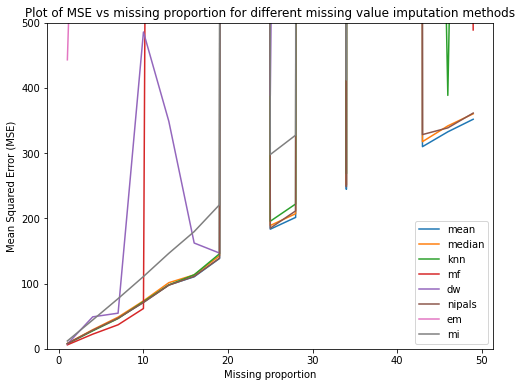

In [30]:
plt.figure(figsize=(8, 6))
plt.plot(plotDf.missing_proportion, plotDf.mean_mse, label='mean')
plt.plot(plotDf.missing_proportion, plotDf.median_mse, label='median')
plt.plot(plotDf.missing_proportion, plotDf.knn_mse, label='knn')
plt.plot(plotDf.missing_proportion, plotDf.mf_mse, label='mf')
plt.plot(plotDf.missing_proportion, plotDf.dw_mse, label='dw')
plt.plot(plotDf.missing_proportion, plotDf.nipals_mse, label='nipals')
plt.plot(plotDf.missing_proportion, plotDf.em_mse, label='em')
plt.plot(plotDf.missing_proportion, plotDf.mi_mse, label='mi')
plt.ylim([0, 500])
plt.title('Plot of MSE vs missing proportion for different missing value imputation methods')
plt.xlabel('Missing proportion')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()
plt.show()

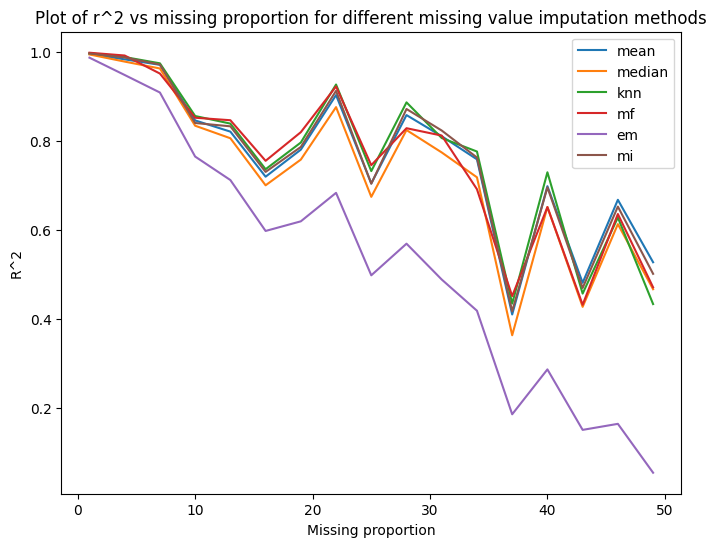

In [36]:
from matplotlib import pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(plotDf.missing_proportion, plotDf.mean_r2, label='mean')
plt.plot(plotDf.missing_proportion, plotDf.median_r2, label='median')
plt.plot(plotDf.missing_proportion, plotDf.knn_r2, label='knn')
plt.plot(plotDf.missing_proportion, plotDf.mf_r2, label='mf')
# plt.plot(plotDf.missing_proportion, [r2 if r2 > 0 else np.nan for r2 in plotDf.dw_r2], label='dw')
# plt.plot(plotDf.missing_proportion, plotDf.nipals_r2, label='nipals')
plt.plot(plotDf.missing_proportion, plotDf.em_r2, label='em')
plt.plot(plotDf.missing_proportion, plotDf.mi_r2, label='mi')
plt.title('Plot of r^2 vs missing proportion for different missing value imputation methods')
plt.xlabel('Missing proportion')
plt.ylabel('R^2')
plt.legend()
plt.show()

## Imputation for different number of variables in missing data

In [21]:
plotData1 = []
cols = []
for index, value in missingSeries.items():
    print(f"Index : {index}, Value : {value}")
    cols.append(index)
    
    if len(cols) <3:
        continue

    subDf = dataDf[cols]
    mask = np.random.choice(a=[True, False], size=subDf.shape, p=[0.1, 0.9])
    submaskedDf = subDf.mask(mask)

    meanImputer = SimpleImputer(strategy='mean')
    meanImputedData = meanImputer.fit_transform(submaskedDf)
    meanImputedDf = pd.DataFrame(meanImputedData, columns=[(col + '_mean') for col in submaskedDf.columns], index=submaskedDf.index)
    meanMse = mean_squared_error(subDf, meanImputedDf)
    meanR2 = r2_score(subDf, meanImputedDf)

    medianImputer = SimpleImputer(strategy='median')
    medianImputedData = medianImputer.fit_transform(submaskedDf)
    medianImputedDf = pd.DataFrame(medianImputedData, columns=[(col + '_median') for col in submaskedDf.columns], index=submaskedDf.index)
    medianMse = mean_squared_error(subDf, medianImputedDf)
    medianR2 = r2_score(subDf, medianImputedDf)

    knnImputer = KNNImputer()
    knnImputedData = knnImputer.fit_transform(submaskedDf)
    knnImputedDf = pd.DataFrame(knnImputedData, columns=[(col + '_knn') for col in submaskedDf.columns], index=submaskedDf.index)
    knnMse = mean_squared_error(subDf, knnImputedDf)
    knnR2 = r2_score(subDf, knnImputedDf)

    mfImputer = MissForest()
    mfImputedData = mfImputer.fit_transform(submaskedDf)
    mfImputedDf = pd.DataFrame(mfImputedData, columns=[(col + '_mf') for col in submaskedDf.columns], index=submaskedDf.index)
    mfMse = mean_squared_error(subDf, mfImputedDf)
    mfR2 = r2_score(subDf, mfImputedDf)

    try:
        pc = PCA(data=submaskedDf, ncomp=1, missing='fill-em', method='nipals')
        nipalsMmputedDf = pd.DataFrame(pc._adjusted_data)
        nipalsMse = mean_squared_error(subDf, nipalsMmputedDf)
        nipalsR2 = r2_score(subDf, nipalsImputedDf)
    except:
        nipalsMse = 0

    dwImputedDf = datawig.SimpleImputer.complete(submaskedDf)
    dwMse = mean_squared_error(subDf, dwImputedDf)
    dwR2 = r2_score(subDf, dwImputedDf)

    emImputedData = impy.em(submaskedDf.to_numpy())
    emImputedDataDf = pd.DataFrame(emImputedData, columns=[(col + '_em') for col in submaskedDf.columns], index=submaskedDf.index)
    emMse = mean_squared_error(subDf, emImputedDataDf)
    emR2 = r2_score(subDf, emImputedDataDf)

    # Create kernel. 
    miKernel = mf.ImputationKernel(
      submaskedDf,
      datasets=4,
      save_all_iterations=True,
      random_state=1
    )
    # Run the MICE algorithm for 2 iterations on each of the datasets
    miKernel.mice(2)
    miImputedDataDf = miKernel.complete_data(dataset=0, inplace=False)
    miImputedDf = pd.DataFrame(miImputedDataDf.to_numpy(), columns=[(col + '_mi') for col in submaskedDf.columns], index=submaskedDf.index)
    miMse = mean_squared_error(subDf, miImputedDf)
    miR2 = r2_score(subDf, miImputedDf)

    plotData1.append([str(len(cols)), meanMse, medianMse, knnMse, mfMse, nipalsMse, dwMse, emMse, miMse, meanR2, medianR2, knnR2, mfR2, nipalsR2, dwR2, emR2, miR2])

plotDf1 = pd.DataFrame(plotData1, columns=['no_of_cols', 'mean_mse', 'median_mse', 'knn_mse', 'mf_mse', 'nipals_mse', 'dw_mse', 'em_mse', 'mi_mse', 'mean_r2', 'median_r2', 'knn_r2', 'mf_r2', 'nipals_r2', 'dw_r2', 'em_r2', 'mi_r2'])

Index : creatinine, Value : 214
Index : potassium, Value : 229
Index : glucose, Value : 235
Iteration: 0
Iteration: 1


/superbugai-data/yash/chapter_1/workspace/EHRQC/notebooks/.venv/lib/python3.9/site-packages/lightgbm/engine.py:240: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/superbugai-data/yash/chapter_1/workspace/EHRQC/notebooks/.venv/lib/python3.9/site-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


Index : urea_nitrogen, Value : 242
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4


/superbugai-data/yash/chapter_1/workspace/EHRQC/notebooks/.venv/lib/python3.9/site-packages/lightgbm/engine.py:240: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/superbugai-data/yash/chapter_1/workspace/EHRQC/notebooks/.venv/lib/python3.9/site-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


Index : chloride, Value : 253
Iteration: 0
Iteration: 1


/superbugai-data/yash/chapter_1/workspace/EHRQC/notebooks/.venv/lib/python3.9/site-packages/lightgbm/engine.py:240: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/superbugai-data/yash/chapter_1/workspace/EHRQC/notebooks/.venv/lib/python3.9/site-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


Index : sodium, Value : 253
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


/superbugai-data/yash/chapter_1/workspace/EHRQC/notebooks/.venv/lib/python3.9/site-packages/lightgbm/engine.py:240: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/superbugai-data/yash/chapter_1/workspace/EHRQC/notebooks/.venv/lib/python3.9/site-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


Index : hematocrit, Value : 254
Iteration: 0
Iteration: 1


/superbugai-data/yash/chapter_1/workspace/EHRQC/notebooks/.venv/lib/python3.9/site-packages/lightgbm/engine.py:240: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/superbugai-data/yash/chapter_1/workspace/EHRQC/notebooks/.venv/lib/python3.9/site-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


Index : bicarbonate, Value : 292
Iteration: 0
Iteration: 1
Iteration: 2


/superbugai-data/yash/chapter_1/workspace/EHRQC/notebooks/.venv/lib/python3.9/site-packages/lightgbm/engine.py:240: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/superbugai-data/yash/chapter_1/workspace/EHRQC/notebooks/.venv/lib/python3.9/site-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


Index : hemoglobin, Value : 311
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


/superbugai-data/yash/chapter_1/workspace/EHRQC/notebooks/.venv/lib/python3.9/site-packages/lightgbm/engine.py:240: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/superbugai-data/yash/chapter_1/workspace/EHRQC/notebooks/.venv/lib/python3.9/site-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


Index : anion_gap, Value : 314
Iteration: 0
Iteration: 1
Iteration: 2


/superbugai-data/yash/chapter_1/workspace/EHRQC/notebooks/.venv/lib/python3.9/site-packages/lightgbm/engine.py:240: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/superbugai-data/yash/chapter_1/workspace/EHRQC/notebooks/.venv/lib/python3.9/site-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


Index : platelet_count, Value : 342
Iteration: 0
Iteration: 1
Iteration: 2


/superbugai-data/yash/chapter_1/workspace/EHRQC/notebooks/.venv/lib/python3.9/site-packages/lightgbm/engine.py:240: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/superbugai-data/yash/chapter_1/workspace/EHRQC/notebooks/.venv/lib/python3.9/site-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


Index : white_blood_cells, Value : 344
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


/superbugai-data/yash/chapter_1/workspace/EHRQC/notebooks/.venv/lib/python3.9/site-packages/lightgbm/engine.py:240: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/superbugai-data/yash/chapter_1/workspace/EHRQC/notebooks/.venv/lib/python3.9/site-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


Index : red_blood_cells, Value : 357
Iteration: 0
Iteration: 1
Iteration: 2


/superbugai-data/yash/chapter_1/workspace/EHRQC/notebooks/.venv/lib/python3.9/site-packages/lightgbm/engine.py:240: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/superbugai-data/yash/chapter_1/workspace/EHRQC/notebooks/.venv/lib/python3.9/site-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


Index : mcv, Value : 358
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


/superbugai-data/yash/chapter_1/workspace/EHRQC/notebooks/.venv/lib/python3.9/site-packages/lightgbm/engine.py:240: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/superbugai-data/yash/chapter_1/workspace/EHRQC/notebooks/.venv/lib/python3.9/site-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


Index : mchc, Value : 363
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


/superbugai-data/yash/chapter_1/workspace/EHRQC/notebooks/.venv/lib/python3.9/site-packages/lightgbm/engine.py:240: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/superbugai-data/yash/chapter_1/workspace/EHRQC/notebooks/.venv/lib/python3.9/site-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


Index : mch, Value : 364
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


/superbugai-data/yash/chapter_1/workspace/EHRQC/notebooks/.venv/lib/python3.9/site-packages/lightgbm/engine.py:240: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/superbugai-data/yash/chapter_1/workspace/EHRQC/notebooks/.venv/lib/python3.9/site-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


Index : rdw, Value : 371
Iteration: 0
Iteration: 1
Iteration: 2


/superbugai-data/yash/chapter_1/workspace/EHRQC/notebooks/.venv/lib/python3.9/site-packages/lightgbm/engine.py:240: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/superbugai-data/yash/chapter_1/workspace/EHRQC/notebooks/.venv/lib/python3.9/site-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


Index : magnesium, Value : 1264
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


/superbugai-data/yash/chapter_1/workspace/EHRQC/notebooks/.venv/lib/python3.9/site-packages/lightgbm/engine.py:240: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/superbugai-data/yash/chapter_1/workspace/EHRQC/notebooks/.venv/lib/python3.9/site-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


Index : calcium_total, Value : 3389
Iteration: 0
Iteration: 1


/superbugai-data/yash/chapter_1/workspace/EHRQC/notebooks/.venv/lib/python3.9/site-packages/lightgbm/engine.py:240: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/superbugai-data/yash/chapter_1/workspace/EHRQC/notebooks/.venv/lib/python3.9/site-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


Index : phosphate, Value : 3413
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


/superbugai-data/yash/chapter_1/workspace/EHRQC/notebooks/.venv/lib/python3.9/site-packages/lightgbm/engine.py:240: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/superbugai-data/yash/chapter_1/workspace/EHRQC/notebooks/.venv/lib/python3.9/site-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


In [22]:
plotDf1.to_csv('temp_plot_df_1.csv')

In [23]:
plotDf1

,no_of_cols,mean_mse,median_mse,knn_mse,mf_mse,nipals_mse,dw_mse,em_mse,mi_mse,mean_r2,median_r2,knn_r2,mf_r2,nipals_r2,dw_r2,em_r2,mi_r2
0,3,110.925804,117.586725,2.705089e+04,140.847607,0.000000,3209.724031,28732.752656,213.227944,0.933638,0.929760,0.903614,0.929640,0.568281,-4.387025,0.844604,0.890120
1,4,253458.379105,253491.931923,2.535012e+05,253422.204342,0.000000,253432.895406,253466.793344,253614.063952,0.672748,0.666935,0.675981,0.692320,0.568281,0.700671,0.605266,0.656912
2,5,67.222370,70.632817,1.353950e+06,67.038268,0.000000,8737.968926,18033.503032,128.366263,0.919635,0.915195,-0.416634,0.940259,0.568281,0.312541,0.832588,0.894095
3,6,61.348894,64.900333,6.974401e+01,58.040490,0.000000,54.648809,15066.436684,98.426837,0.914667,0.910795,0.916559,0.947990,0.568281,0.951437,0.826244,0.908620
4,7,53.140119,56.403967,5.713377e+01,191.832967,0.000000,105.506952,12502.811654,92.993562,0.915003,0.912276,0.916817,0.946722,0.568281,0.947564,0.825232,0.900502
5,8,46.929236,49.851341,5.064113e+03,11474.187174,0.000000,992.971945,11404.439890,78.705613,0.913155,0.910357,0.913938,0.940217,0.568281,-1.236320,0.824116,0.907925
6,9,43.342744,45.871312,4.617615e+01,46.854392,0.000000,306.068600,9994.791966,68.871439,0.912931,0.910466,0.929098,0.963536,0.568281,0.534450,0.823543,0.929345
7,10,37.323308,39.811420,3.898996e+01,566.515983,0.000000,68.374405,9044.167707,62.424747,0.910526,0.908109,0.934246,0.968793,0.568281,0.940058,0.820900,0.936572
8,11,132.599344,136.703455,1.454136e+02,126.578488,0.000000,132.767209,8094.871035,226.078757,0.908396,0.905992,0.931733,0.963890,0.568281,0.932995,0.819970,0.926875
9,12,119.798777,123.901256,1.239986e+02,234.956522,0.000000,304.103138,7697.226135,192.056187,0.911036,0.908659,0.928130,0.961201,0.568281,0.417331,0.820756,0.917971


In [7]:
import pandas as pd

plotDf1 = pd.read_csv('temp_plot_df_1.csv')

In [8]:
plotDf1

,Unnamed: 0,no_of_cols,mean_mse,median_mse,knn_mse,mf_mse,dw_mse,nipals_mse,em_mse,mi_mse,mean_r2,median_r2,knn_r2,mf_r2,nipals_r2,dw_r2,em_r2,mi_r2
0,0,3,14.843361,14.651589,69.635516,884.332098,583.297505,10035.43867,5030.291106,655.529411,0.969853,0.969664,0.963474,0.959567,0.875834,-1.072553,0.881211,0.941313
1,1,4,11.912736,11.764472,28.031418,639.910799,583.297505,10035.43867,4073.222461,20.582860,0.976516,0.976341,0.973009,0.956263,0.875834,-1.072553,0.887601,0.958259
2,2,5,884.683297,885.003605,887.727723,894.580367,1703.275704,10035.43867,4336.572392,889.213515,0.838056,0.837927,0.834979,0.838264,0.875834,-1.072553,0.759945,0.824965
3,3,6,2900.741472,2901.053898,2901.814719,2950.863005,3025.711492,10035.43867,5604.388235,2898.689786,0.778767,0.778569,0.775066,0.779423,0.875834,-1.072553,0.704545,0.768477
4,4,7,2386.338293,2386.470108,2401.241873,2402.427827,2470.226258,10035.43867,4706.037442,2385.884809,0.811919,0.807306,0.808230,0.814311,0.875834,-1.072553,0.734330,0.795229
5,5,8,327.719686,328.131300,2720.638576,353.098076,408.852430,10035.43867,2578.134667,327.086061,0.941288,0.929402,0.915081,0.955608,0.875834,-1.072553,0.851136,0.941569
6,6,9,43.355447,43.386568,400.412797,1736.698528,43.435558,10035.43867,1987.880787,45.870608,0.948804,0.934864,0.923576,0.957659,0.875834,-1.072553,0.856750,0.960697
7,7,10,7300.379029,7300.616122,7306.074231,7444.121361,7306.628347,10035.43867,8485.015076,7302.686456,0.854897,0.843543,0.868061,0.870976,-3116.775611,-1.072553,0.770364,0.866744


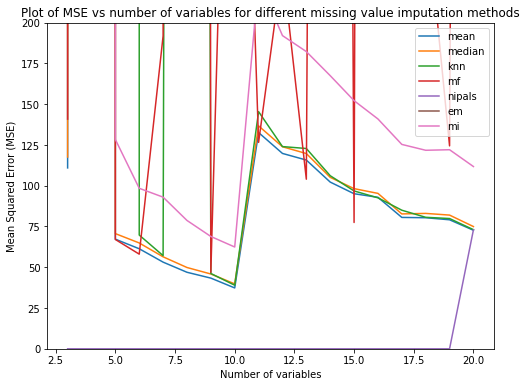

In [33]:
plt.figure(figsize=(8, 6))
plt.plot(plotDf1.no_of_cols, plotDf1.mean_mse, label='mean')
plt.plot(plotDf1.no_of_cols, plotDf1.median_mse, label='median')
plt.plot(plotDf1.no_of_cols, plotDf1.knn_mse, label='knn')
plt.plot(plotDf1.no_of_cols, plotDf1.mf_mse, label='mf')
plt.plot(plotDf1.no_of_cols, plotDf1.nipals_mse, label='nipals')
plt.plot(plotDf1.no_of_cols, plotDf1.em_mse, label='em')
plt.plot(plotDf1.no_of_cols, plotDf1.mi_mse, label='mi')
plt.ylim([0, 200])
plt.title('Plot of MSE vs number of variables for different missing value imputation methods')
plt.xlabel('Number of variables')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()
plt.show()

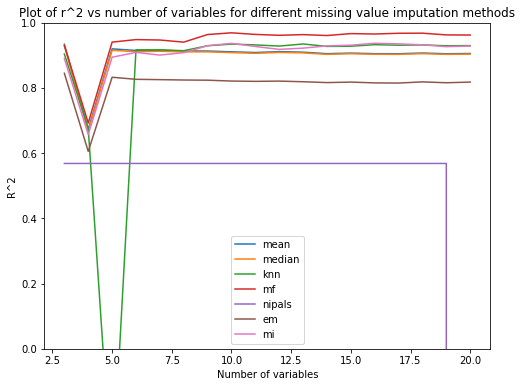

In [32]:
plt.figure(figsize=(8, 6))
plt.plot(plotDf1.no_of_cols, plotDf1.mean_r2, label='mean')
plt.plot(plotDf1.no_of_cols, plotDf1.median_r2, label='median')
plt.plot(plotDf1.no_of_cols, plotDf1.knn_r2, label='knn')
plt.plot(plotDf1.no_of_cols, plotDf1.mf_r2, label='mf')
plt.plot(plotDf1.no_of_cols, plotDf1.nipals_r2, label='nipals')
plt.plot(plotDf1.no_of_cols, plotDf1.em_r2, label='em')
plt.plot(plotDf1.no_of_cols, plotDf1.mi_r2, label='mi')
plt.ylim([0, 1])
plt.title('Plot of r^2 vs number of variables for different missing value imputation methods')
plt.xlabel('Number of variables')
plt.ylabel('R^2')
plt.legend()
plt.show()

## MissForest imputation evaluation

In [40]:
import warnings
warnings.filterwarnings('ignore')

data = []
for p in range(5, 40, 15):

    print('p: ', p)

    proportions = (p/100), round((1-(p/100)), 2)
    mask = np.random.choice(a=[True, False], size=dataDf.shape, p=proportions)
    missingDf = dataDf.mask(mask)

    mfImputer = MissForest()
    imputedData = mfImputer.fit_transform(missingDf)
    imputedDf = pd.DataFrame(imputedData, columns=[(col + '_mf') for col in missingDf.columns], index=missingDf.index)

    data.append([p, missingDf, imputedDf])

p:  5
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
p:  20
Iteration: 0
Iteration: 1
Iteration: 2
p:  35
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5


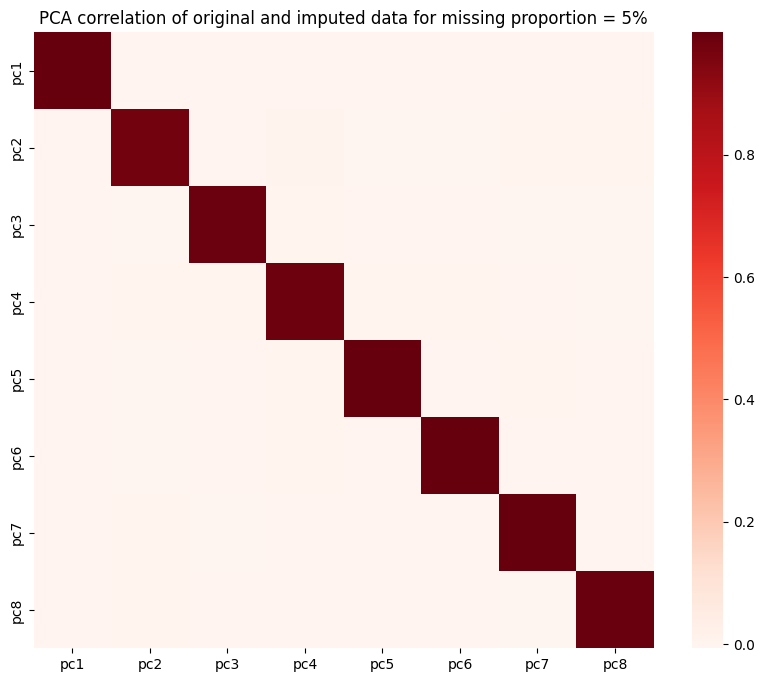

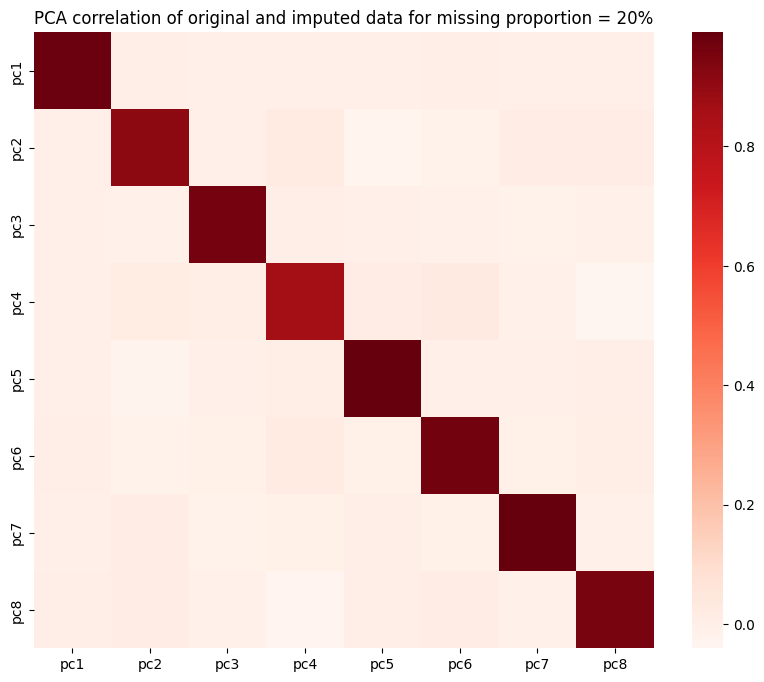

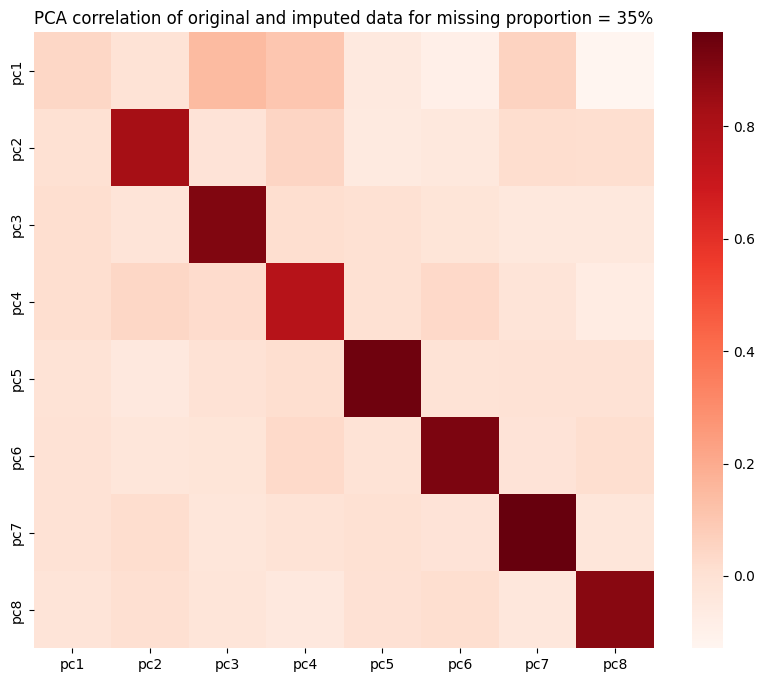

In [42]:
pca = sklearnPCA(n_components=8)
pcaModel = pca.fit(dataDf)
for i in range(len(data)):

    dataPc = pca.transform(dataDf)
    dataPcDf = pd.DataFrame(data = dataPc, columns = ['pc1', 'pc2', 'pc3', 'pc4', 'pc5', 'pc6', 'pc7', 'pc8'])

    data[i][2].columns = dataDf.columns

    missingPc = pca.transform(data[i][2])
    missingPcDf = pd.DataFrame(data = missingPc, columns = ['pc1', 'pc2', 'pc3', 'pc4', 'pc5', 'pc6', 'pc7', 'pc8'])

    plt.figure(figsize=(10, 8))
    sns.heatmap(pd.concat([dataPcDf, missingPcDf], axis=1, keys=['df1', 'df2']).corr().loc['df2', 'df1'], cmap="Reds")
    plt.title('PCA correlation of original and imputed data for missing proportion = ' + str(data[i][0]) + '%')
    plt.show()